## Génération du Markov Decision Process

### Définition du problème :

Un agent se trouve sur une case aléatoire d'une grille 4 $\times$ 4, sur la majorité des case de cette grille se trouvent des malus de score qui sont appliqués lorsqu'on marche dessus. Sur une faible fraction des cases se trouve un trésor, qui offre une récompense. Le but de l'agent est de maximiser sa récompense, en outre, il doit trouver le plus court chemin vers le trésor. Voici la grille des états :

$$grid = \begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 0 & 7 & 8 \\
9 & 10 & 11 & 12 \\
0 & 14 & 15 & 16 
\end{bmatrix}$$

On remarque que certains états sont impossibles, il y a des obstacles dessus, ce qui est traduit par une étoile sur la case correspondante.

D'après la définition du problème, la fonction de récompense ne dépend que de la case sur laquelle l'agent se déplace à un certain instant. On a donc $R:S\to \mathbb{R}$. Voici la matrice de récompense :
$$R=\begin{bmatrix}
-0.1 & -0.1 & -0.1 & -0.1 \\
- 1 & 0 & -0.1 & -0.1 \\
-0.1 & -0.1 & -0.1 & -0.1 \\
0 & 1 & -0.1 & -0.1
\end{bmatrix}$$

Les actions que peut prendre l'agent sont des déplacements dans les 4 directions, cependant, ces actions ne sont pas déterministes, l'agent ne peut que "essayer" d'aller dans une direction. Toutefois, s'il essaie d'aller dans une direction, il n'est pas possible qu'il aille à l'opposé. Par exemple, si l'agent prend l'action "essayer d'aller en haut", il n'est pas possible qu'il aille en bas, par contre il peut aller à gauche ou à droite avec une probabilité faible.





### Import des librairies



In [86]:
import numpy as np

### Définition des actions

In [87]:
## dans le sens des aiguilles d'une montre

actions = {'up' : [0.8,0.1,0.,0.1], 
           'right':[0.1,0.8,0.1,0], 
           'down':[0.,0.1,0.8,0.1], 
           'left':[0.1,0.,0.1,0.8]}

### Définition de la matrice représentative de la grille

In [88]:
grid = np.array([[1,2,3,4],
                 [5,0,7,8],
                 [9,10,11,12],
                 [0,14,15,16]]
               )
n_col = grid.shape[1]

### Définition de la matrice d'adjacence

In [89]:
## cases numérotées de gauche à droite et de haut en bas

n_states = np.prod(grid.shape)
adj = np.zeros((n_states, n_states))

for i in range (0, n_states) :
    for j in range (0, n_states) :
    # Si on est sur un état adjacent, et que cet état n'est pas obstrué, on met un 1 qui signifie qu'on peut aller sur cet état à partir
    # de l'état où l'on est
        if (j == i - n_col or j == i+1 or j == i + n_col or j == i-1) and grid[j//n_col,j%n_col]!=0 :
            adj[i,j] = 1

print(adj)

[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]


Une fois que l'on a la matrice d'adjacence, les matrices de transitions ne sont que des déclinaisons de cette matrice.
### Définition des matrices de transition

On considère que quelque soit l'état, on peut essayer d'aller dans toutes les directions. Cependant, les matrices de transitions doivent être stochastiques donc on modifie leur contenu de sorte que la somme de chaque ligne vale 1.

In [90]:
T = []
adj_coor = [-n_col, 1,n_col, -1]
for action in actions :
    Ta = np.zeros((n_states,n_states))
    p = actions[action]
    for i in range (0, n_states) :
        for k in range(len(p)):
            j = i+adj_coor[k]
            if 0<=j<=15:
                Ta[i, j] = adj[i, j]*p[k]
                Lsum = np.sum(Ta[i,:])
        if Lsum !=1:
            Ta[i,:]*=1/Lsum
    T.append(Ta)

T = np.array(T)

In [91]:
T.shape

(4, 16, 16)

In [92]:
print(T[2,11,:])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11111111 0.
 0.         0.         0.         0.88888889]


### Définition des matrices de récompense

In [93]:
R = np.array([-0.1, -0.1, -0.1, -0.1,
              -1, 0, -0.1, -0.1,
              -0.1, -0.1, -0.1, -0.1,
              0, 1, -0.1,-0.1]).transpose()
print(R)

[-0.1 -0.1 -0.1 -0.1 -1.   0.  -0.1 -0.1 -0.1 -0.1 -0.1 -0.1  0.   1.
 -0.1 -0.1]


In [94]:
## Autres rewards

R2 = np.array([-0.4, -0.4, -0.4, -0.4,
               -20, 0, -0.4, -0.4,
               -0.4, -0.4, -0.4, -0.4,
               0, 20, -0.4, -0.4]).transpose()

In [95]:
R.shape

(16,)

# Algorithme de décision : Policy Iteration.

Notre système est défini par un Markov Decision Process (matrice de transition T, matrice de récompense R, états S, ici matrice adjacence et grille).

Nous cherchons la politique optimale avec l'algorithme de Policy Iteration.

## 1. Utilisation de la toolbox MDP

Doc : https://pymdptoolbox.readthedocs.io/en/latest/api/mdp.html

In [96]:
T[2,11,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11111111, 0.        , 0.        , 0.        , 0.        ,
       0.88888889])

In [97]:
import mdptoolbox

val_it = mdptoolbox.mdp.ValueIteration(T, R, 0.96)
val_it.run()
pol = val_it.policy
pol

(0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2)

In [98]:
## Tests sur les rewards

val_it2 = mdptoolbox.mdp.ValueIteration(T, R2, 0.96)
val_it2.run()
val_it2.policy

(0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2)

In [99]:
T[0,0,:]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [100]:
T[2,15,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

## 2. Algorithme codé à la main

In [101]:
from copy import copy
import random

#Variables pour mesure de performance 
U_evols = []
policy_evols = []
policyOpt = [0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2]
UOpt  =  [6.71647618,7.10954292,7.50979658,7.31123984,
          6.94739605,8.42745225,8.11731324,7.84756951,
          8.39900898,9.10261282,8.64799512,8.29045024,
          9.30254853,9.8502506 ,9.22911691,8.7502506 ]


# 1ère Méthode Value Iteration 

def value_iteration(T, R, discount):
    U  = copy(R)
    U_ = copy(R)
    
    epsilon  = 10**-2
    DiffUtil = 10
    
    while DiffUtil > epsilon : 
        U = copy(U_)
        
        
        #Ligne pour évaluation de la convergence 
        U_evols.append(abs(U - UOpt))
        
        for state in range(16):
            U_[state] = R[state] + discount * max([sum([T[a, state, j]*U[j] for j in range(16)]) for a in range(4)])
        DiffUtil = max(abs(U - U_))
    return U

def utilities_opt_policy(U, T):
    
    policy = [random.randint(0,3) for i in range(16)]
    for state in range(16):
        PU_List = [sum([T[a, state, j]*U[j] for j in range(16)]) for a in range(4)]
        policy[state] = PU_List.index(max(PU_List))
    return policy
    
# 2ème méthode Policy Iteration     

def policy_iteration(T, R, discount):
    U = copy(R)
    policy = utilities_opt_policy(U,T)
    
    
    
    changed = True
    while changed == True:
        for state in range(16):
            U[state] = R[state] + discount*sum([T[policy[state], state, j]*U[j] for j in range(16)])
        changed = False 
        
        
        for state in range(16):
            if max([sum([T[a, state, j]*U[j] for j in range(16)]) for a in range(4)]) > sum([T[policy[state], state, j]*U[j] for j in range(16)]):
                PU_List = [sum([T[a, state, j]*U[j] for j in range(16)]) for a in range(4)]
                policy[state] = PU_List.index(max(PU_List))
                changed = True
        
        # Ligne pour evaluation convergence       
        policy_evols.append(hamming_loss(policy, policyOpt))
        
    return policy

def hamming_loss(l1, l2):
    loss = 0
    for i in range(min(len(l1), len(l2))):
        if l1[i] != l2[i]:
            loss += 1
    return loss

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#



"""
Test de Value Iteration avec Discount = 0.96 et R
"""    

U  =  value_iteration(T, R, 0.96)
print("Utilities : "+str(U))
print("La politique optimale est (Value Iteration ): "+str(utilities_opt_policy(U, T)))

#(0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2)

# L'algorithme de Value Iteration donne les mêmes résultats que MDP.ValueIteration


"""
Test de Policy Iteration avec Discount = 0.96 et R 
"""

policy = policy_iteration(T, R, 0.96)
print("La politique optimale est (Policy Iteration ): "+str(policy))

#L'algorithme de Policy Iteration donne les mêmes résultats que MDP.PolicyIteration


Utilities : [6.71647618 7.10954292 7.50979658 7.31123984 6.94739605 8.42745225
 8.11731324 7.84756951 8.39900898 9.10261282 8.64799512 8.29045024
 9.30254853 9.8502506  9.22911691 8.7502506 ]
La politique optimale est (Value Iteration ): [0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2]
La politique optimale est (Policy Iteration ): [0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2]


## 2.2 Visualisation de la convergence de l'algorithme

Pour visualiser la convergence des 2 algorithmes nous avons procédé comme suit :
    - Value Iteration : Nous tracons pour chaque case ( state ) l'évolution de la différence entre
    l'utilité à l'itération t et l'utilité optimale 
    - Policy iteration : Nous introduisons la notion de policy loss qui est analogue au Hamming loss, qui est égale      à : $\begin{align*}
         \sum {s = 1}{s = 16} I(\pi(s_i), \pi*(s_i))
         \end{align*}$

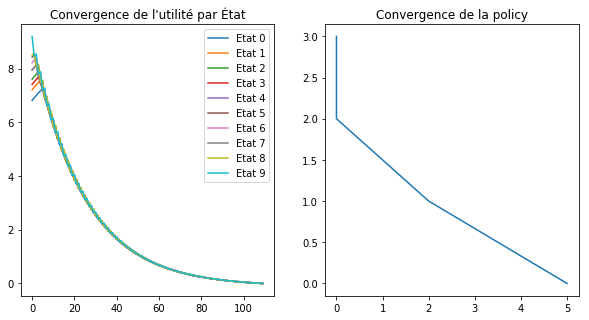

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Plot uniquement pour 
for i in range(10):
    state_values = [utilities[i] for utilities in U_evols]
    axes[0].plot(list(range(len(U_evols))), state_values, label = "Etat "+str(i))
    axes[0].legend()
    axes[0].set_title("Convergence de l'utilité par État")

axes[1].plot(policy_evols, range(len(policy_evols)))
axes[1].set_title("Convergence de la policy")
plt.show()




Nous remarquons que L'algorithme de Policy Iteration converge plus rapidement que l'algorithme de value Iteration

## 3. Définition de l'agent

In [177]:
from scipy import stats

class Agent:
    
    def __init__(self, T, position, policy):
        
        self.T = T
        self.policy = policy
        self.position = position
        self.history = []
    
    def goToNext(self):
        
        action_recommande = self.policy[self.position]
        distribution_prochain_etat = self.T[action_recommande, self.position, :].tolist()
        
        probs, etats = [], []
        
        for j in range(len(distribution_prochain_etat)):
            if distribution_prochain_etat[j] != 0:
                probs.append(distribution_prochain_etat[j])
                etats.append(j)
        
        # prochain_etat = np.random.choice(etats, 1, probs)
        
        custm = stats.rv_discrete(name="custm", values=(etats, probs))
        
        prochain_etat = custm.rvs(size=1)
        
        self.history.append( (self.position, prochain_etat[0], action_recommande) )
        self.position = prochain_etat[0]
    
        #print("nouvelle position: ", self.position)
        
    def getHistory(self):
        return self.history

In [150]:
agent = Agent(T, 0, pol)

In [158]:
agent.goToNext()

nouvelle position:  13


In [159]:
agent.getHistory()

[(0, 1, 0),
 (1, 2, 1),
 (2, 6, 2),
 (6, 10, 2),
 (10, 11, 2),
 (11, 15, 2),
 (15, 14, 2),
 (14, 13, 3)]

In [191]:
def experiment_discount_factor(inf, sup, step, epochs):
    
    times = []
    
    for d in np.arange(inf, sup, step):
        
        
        val_it = mdptoolbox.mdp.ValueIteration(T, R, 0.96)
        val_it.run()
        pol = val_it.policy
        
        time = []
        for i in range(epochs):
            agent = Agent(T, 0, pol)

            while agent.position != 13:
                agent.goToNext()
                
            time.append(len(agent.getHistory()))

        times.append(np.mean(time))
    
    plt.figure(figsize=(10,6))
    x = np.arange(inf, sup, step)
    y = times
    plt.scatter(x,
                y)
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.show()

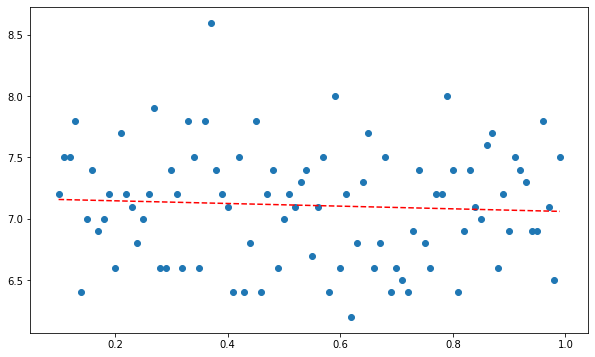

In [192]:
experiment_discount_factor(0.1, 1, 0.01, epochs=10)